# Transfer Learning avec Pytorch

Pour illustrer l'intêret du *transfer learning*, nous allons utiliser un dataset assez petit contenant des images de fourmis et d'abeilles. On va chercher à entrainer un modèle pour classifier si l'insecte sur l'image est une fourmi ou une abeille. Ce code s'inspire de l'[exemple de fine-tuning de pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).  
Vous pouvez télécharger le dataset en cliquant sur ce [lien](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

Commençons par charger notre dataset : 

In [47]:
# Transformation des données
transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # moyenne et ecart type utilisé pour le pre-entrainement
    ])

# Chemin vers les données
data_dir = '../data/hymenoptera_data' 

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
val_data= datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4,shuffle=True, num_workers=4)


class_names = train_data.classes
print("Classes du dataset : ",class_names)

print("Nombre d'images d'entrainement : ",len(train_data))
print("Nombre d'images de validation : ",len(val_data))


Classes du dataset :  ['ants', 'bees']
Nombre d'images d'entrainement :  244
Nombre d'images de validation :  153


Comme vous le voyez, on dispose de très peu d'images. On peut visualiser quelques éléments de notre dataset : 

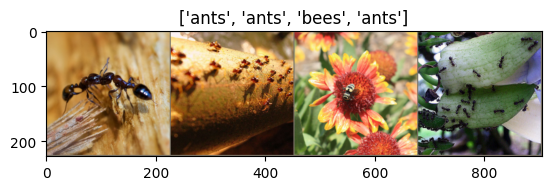

In [79]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Le dataset a l'air assez compliqué, parfois les insectes occupent une très petite place dans l'image.

## Création du modèle

Pour le modèle, on utilise l'architecture de [resnet18](https://arxiv.org/pdf/1512.03385) qui est une architecture assez légére et très performante pour les problèmes de classification.

In [62]:
class modified_resnet18(nn.Module):
  def __init__(self,weights=None,out_class=2):
    super(modified_resnet18, self).__init__()
    # On charge le modèle pré-entrainé. Si weights=None, on charge le modèle sans les poids pré-entrainés
    self.resnet18 = models.resnet18(weights=weights) 
    # On remplace la dernière couche du modèle pour correspondre au nombre de classes de notre problème
    self.resnet18.fc = nn.Linear(512, out_class)
  
  def forward(self,x):
    return self.resnet18(x)

## Entraînement sans transfer learning

Dans un premier temps, nous allons essayer d'entraîner notre modèle à partir de zéro.

In [64]:
model = modified_resnet18(weights=None,out_class=len(class_names)) #weights=None pour charger le modèle sans les poids pré-entrainés
model = model.to(device)

lr=0.001
epochs=10

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=lr)

In [65]:
for epoch in range(epochs):
  loss_train=0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_ft.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_ft.step()
    loss_train+=loss.item()
  
  
  model.eval()
  with torch.no_grad():
    loss_val=0
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss_val+=loss.item()
    print(f"Epoch {epoch+1}/{epochs} : train loss : {loss_train/len(train_loader)} val loss : {loss_val/len(val_loader)}")

Epoch 1/10 : train loss : 0.7068140135436761 val loss : 0.6533934359367077
Epoch 2/10 : train loss : 0.7156724578044453 val loss : 0.7215747200907805
Epoch 3/10 : train loss : 0.6751646028190362 val loss : 0.6428722785069392
Epoch 4/10 : train loss : 0.5965930917223946 val loss : 0.7239674238058237
Epoch 5/10 : train loss : 0.6105695530527928 val loss : 0.5773208579764917
Epoch 6/10 : train loss : 0.5515003006477825 val loss : 0.8412383454732406
Epoch 7/10 : train loss : 0.5839061943478272 val loss : 0.6010858137638141
Epoch 8/10 : train loss : 0.5389361244733216 val loss : 0.6349012469634031
Epoch 9/10 : train loss : 0.5367097518727427 val loss : 0.5850474796234033
Epoch 10/10 : train loss : 0.5234740852821068 val loss : 0.782087844151717


On calcule la précision sur nos données de validation : 

In [66]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Précision sur les images de validation: %d %%' % (100 * correct / total))

Précision sur les images de validation: 58 %


La précision est vraiment mauvaise (avec un modèle aléatoire, ça serait 50%)...   

On peut visualiser les prédictions : 

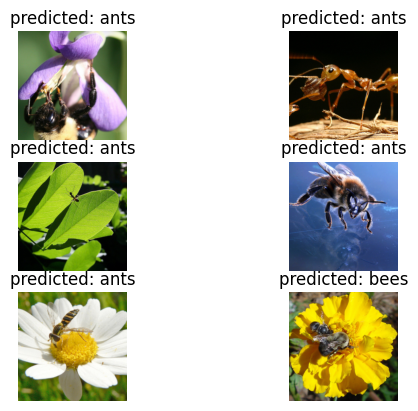

In [71]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], title=f'predicted: {class_names[preds[j]]}')

                if images_so_far == num_images:
                    return
visualize_model(model)

On voit que le modèle fait un peu n'importe quoi. En soit, ce n'est pas étonnant, on dispose de très peu d'images et on sait que, pour entraîner un modèle performant à partir de zéro, il nous faut beaucoup plus d'images (surtout quand il s'agit d'un modèle assez profond).

## Entraînement avec transfer learning

Regardons maintenant ce que l'on peut faire en utilisant du *transfer learning*. La seule chose qui va changer par rapport au code précédent c'est le paramètre weights de notre modèle (et espérons le, les résultats aussi).

In [72]:
model = modified_resnet18(weights='IMAGENET1K_V1',out_class=len(class_names)) #On charge les poids pré-entrainés sur ImageNet
model = model.to(device)

lr=0.001
epochs=10

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=lr)

In [73]:
for epoch in range(epochs):
  loss_train=0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_ft.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_ft.step()
    loss_train+=loss.item()
  
  
  model.eval()
  with torch.no_grad():
    loss_val=0
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss_val+=loss.item()
    print(f"Epoch {epoch+1}/{epochs} : train loss : {loss_train/len(train_loader)} val loss : {loss_val/len(val_loader)}")

Epoch 1/10 : train loss : 0.6442642182600303 val loss : 0.5642786813087952
Epoch 2/10 : train loss : 0.30489559746423706 val loss : 0.26585672435183555
Epoch 3/10 : train loss : 0.10015173801831657 val loss : 0.22248221815635377
Epoch 4/10 : train loss : 0.03893961609325937 val loss : 0.23963456177481043
Epoch 5/10 : train loss : 0.017503870887773446 val loss : 0.21813779352352214
Epoch 6/10 : train loss : 0.011329375068107467 val loss : 0.24817544420903476
Epoch 7/10 : train loss : 0.008011038282496824 val loss : 0.22638171303939694
Epoch 8/10 : train loss : 0.005813347443854284 val loss : 0.2239722229714971
Epoch 9/10 : train loss : 0.004845750937047491 val loss : 0.23538081515699816
Epoch 10/10 : train loss : 0.003927258039885735 val loss : 0.24088036894728504


Calculons la précision sur nos données de validation : 

In [74]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Précision sur les images de validation: %d %%' % (100 * correct / total))

Précision sur les images de validation: 91 %


Le résultat n'a rien à voir. On est passé de 58% de précision à 91% juste grâce à l'utilisation de poids pré-entrainé. 

On peut à nouveau visualiser les prédictions : 

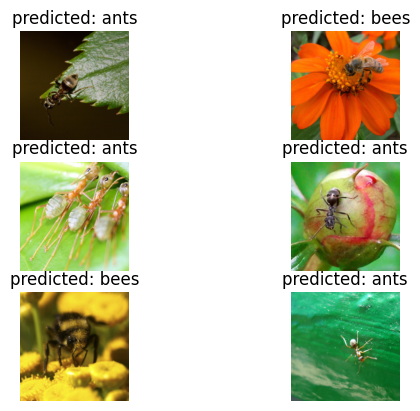

In [75]:
visualize_model(model)

C'est beaucoup mieux ! J'espère que ce cours vous a convaincu de la puissance du *transfer learning* !